## Homework 3
### Part 1: Imbalanced Dataset

## Author: David Palumbo

 In this homework, you will be working with an imbalanced Dataset. The dataset is Credit Card Fraud Detection dataset which was hosted on Kaggle. The aim is to detect fraudlent transactions.

### Instructions

Please push the .ipynb, .py, and .pdf to Github Classroom prior to the deadline. Please include your UNI as well.

### Setup

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

### **Data Preprocessing and Exploration**
Download the Kaggle Credit Card Fraud data set. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [36]:
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### **1.1 Examining the class Imbalance**
**1.1.1 How many observations are in this dataset? How many are positive and negative?**
(Note: Positive labels are labeled as 1)

Number of Observations: 	 284807
Number of positive cases: 	 492
Number of negative cases: 	 284315


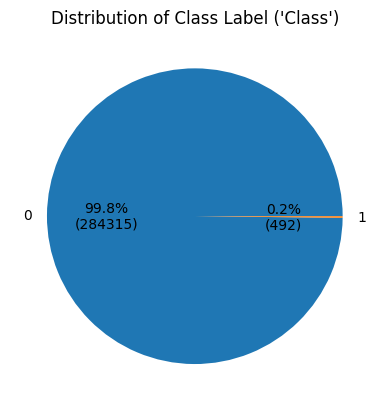

In [37]:
# Your Code here
def pct_func(pct):
    val = int(np.around((pct * len(raw_df))/100))
    return '{p:.1f}%\n({v:d})'.format(p=pct,v=val)

# Not sure what is defined as an observation, so I will assume that just means the number of data entries.
target = "Class"

df_rows = raw_df.groupby(target).size()
df_pos = df_rows[1]
df_neg = df_rows[0]

ax = raw_df.groupby(target).size().plot(kind="pie", autopct=pct_func)
ax.set_title("Distribution of Class Label ('Class')")

print("Number of Observations: \t", df_pos + df_neg)
print("Number of positive cases: \t", df_pos)
print("Number of negative cases: \t", df_neg)

#### **1.2 Cleaning and normalizing the data**
The raw data has a few issues. We are not sure what the time column actually means so drop the Time column. The Amount column also has a wide range of values covered so we take the log of the Amount column to reduce its range.

In [38]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

**1.2.1 Split the dataset into development and test sets. Please set test size as 0.2 and random state as 42. Print the shape of your development and test features**

In [62]:
# Your Code Here
from sklearn.model_selection import train_test_split

# Using stratified split due to heavy imbalance
c_df_X = cleaned_df.drop(columns=[target])
c_df_y = cleaned_df[target]

# We don't end up doing hyperparameter tuning, so we don't really need train/val split, but it doesn't hurt.
# Using stratified splits since the dataset is quite imbalanced
X_dev, X_test, y_dev, y_test = train_test_split(c_df_X, c_df_y, test_size=0.2, random_state=42, stratify=c_df_y)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.2, random_state=42, stratify=y_dev)

print("Train X Shape: \t\t", X_train.shape)
print("Development X Shape: \t", X_dev.shape)
print("Test X Shape: \t\t", X_test.shape)

print("Train y Shape: \t\t", y_train.shape)
print("Development y Shape: \t", y_dev.shape)
print("Test y Shape: \t\t", y_test.shape)

Train X Shape: 		 (182276, 29)
Development X Shape: 	 (227845, 29)
Test X Shape: 		 (56962, 29)
Train y Shape: 		 (182276,)
Development y Shape: 	 (227845,)
Test y Shape: 		 (56962,)


**1.2.2 Normalize the features using Standard Scaler from Sklearn.**

In [63]:
# Your Code Here
from sklearn.preprocessing import StandardScaler

# Helps so that each class has a similar weighted importance at the begining.
scalar  = StandardScaler()
X_dev   = scalar.fit_transform(X_dev)
X_train = scalar.fit_transform(X_train)
X_val   = scalar.fit_transform(X_val)
X_test  = scalar.fit_transform(X_test)

#### **1.3 Defining Model and Performance Metrics**

**1.3.1 First, let us fit a default Decision tree classifier. ( use max_depth=10 and random_state=42). Print the AUC and Average Precision values of 5 Fold Cross Validation**

In [64]:
# Your Code here
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
dt = DecisionTreeClassifier(max_depth=10, random_state=42)

# Using stratified K fold due to the imbalance
kfold = StratifiedKFold(n_splits=5)

dt.fit(X_dev, y_dev)

scores = cross_validate(dt, X=X_dev, y=y_dev, cv=kfold, scoring=['roc_auc', 'average_precision'])

print("AUC: \t\t\t", np.mean(scores['test_roc_auc']))
print("Average Precision: \t", np.mean(scores['test_average_precision']))

AUC: 			 0.8359524571279693
Average Precision: 	 0.641744070059615


**1.3.2 Perform random oversampling on the development dataset.**


*   What many positive and negative labels do you observe after random oversampling?
*   What is the shape of your development dataset?

(Note: Set random state as 42 when performing oversampling)


After Sampling ---
Number of Observations: 	 454902
Number of positive cases: 	 227451
Number of negative cases: 	 227451
Dev Feature Shape:  (454902, 29)


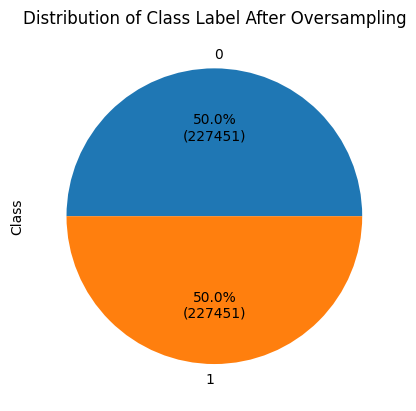

In [65]:
# Your Code here
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_dev_over, y_dev_over = ros.fit_resample(X_dev, y_dev)

val_counts = pd.Series(y_dev_over).value_counts(sort=False)
num_neg = val_counts[0]
num_pos = val_counts[1]
num_rows = num_pos + num_neg

def pct_func(pct):
    val = int(np.around((pct * num_rows)/100))
    return '{p:.1f}%\n({v:d})'.format(p=pct,v=val)

ax = val_counts.plot(kind="pie", autopct=pct_func)
ax.set_title("Distribution of Class Label After Oversampling")

print("After Sampling ---")
print("Number of Observations: \t", num_rows)
print("Number of positive cases: \t", num_pos)
print("Number of negative cases: \t", num_neg)
print("Dev Feature Shape: ", X_dev_over.shape)


**1.3.3 Repeat 1.3.1 using the dataset you created in the above step(1.3.2 Random oversampling). (Make sure you use the same hyperparameters as 1.3.1. i.e., max_depth=10 and random_state=42. This will help us to compare the models)**

In [66]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from imblearn.pipeline import make_pipeline as imb_make_pipeline
dt_over = DecisionTreeClassifier(max_depth=10, random_state=42)

pipeline_over = imb_make_pipeline(ros, dt_over)

# Using stratified K fold due to the imbalance
kfold = StratifiedKFold(n_splits=5)

pipeline_over.fit(X_dev, y_dev)

scores_over = cross_validate(pipeline_over, X=X_dev, y=y_dev, cv=kfold, scoring=['roc_auc', 'average_precision'])

print("AUC: \t\t\t", np.mean(scores_over['test_roc_auc']))
print("Average Precision: \t", np.mean(scores_over['test_average_precision']))

AUC: 			 0.8962802947061006
Average Precision: 	 0.5167581570430926


**1.3.4 Perform Random undersampling on the development dataset**. 
- What many positive and negative labels do you observe after random undersampling?
- What is the shape of your development dataset?
(Note: Set random state as 42 when performing undersampling)

After Sampling ---
Number of Observations: 	 788
Number of positive cases: 	 394
Number of negative cases: 	 394
Dev Feature Shape:  (788, 29)


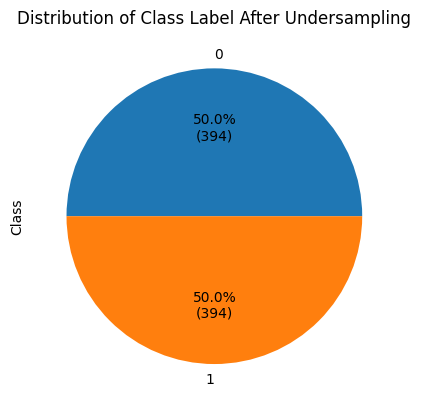

In [67]:
# Your Code here
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_dev_under, y_dev_under = rus.fit_resample(X_dev, y_dev)

val_counts = pd.Series(y_dev_under).value_counts(sort=False)
num_neg = val_counts[0]
num_pos = val_counts[1]
num_rows = num_neg + num_pos

def pct_func(pct):
    val = int(np.around((pct * num_rows)/100))
    return '{p:.1f}%\n({v:d})'.format(p=pct,v=val)

ax = val_counts.plot(kind="pie", autopct=pct_func)
ax.set_title("Distribution of Class Label After Undersampling")

print("After Sampling ---")
print("Number of Observations: \t", num_rows)
print("Number of positive cases: \t", num_pos)
print("Number of negative cases: \t", num_neg)
print("Dev Feature Shape: ", X_dev_under.shape)

**1.3.5 Repeat 1.3.1 using the dataset you created in the above step(1.3.4 Random undersampling). (Make sure you use the same hyperparameters as 1.3.1. i,e., max_depth=10 and random_state=42. This will help us to compare the models)**

In [68]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from imblearn.pipeline import make_pipeline as imb_make_pipeline
dt_under = DecisionTreeClassifier(max_depth=10, random_state=42)

pipeline_under = imb_make_pipeline(rus, dt_under)

# Using stratified K fold due to the imbalance
kfold = StratifiedKFold(n_splits=5)

pipeline_under.fit(X_dev, y_dev)

scores_under = cross_validate(pipeline_under, X=X_dev, y=y_dev, cv=kfold, scoring=['roc_auc', 'average_precision'])

print("AUC: \t\t\t", np.mean(scores_under['test_roc_auc']))
print("Average Precision: \t", np.mean(scores_under['test_average_precision']))

AUC: 			 0.9072986098829894
Average Precision: 	 0.01655060014804277


**1.3.6 Perform Synthetic Minority Oversampling Technique(SMOTE) on the development dataset**
- What many positive and negative labels do you observe after performing SMOTE?
- What is the shape of your development dataset? (Note: Set random state as 42 when performing SMOTE)

After Sampling ---
Number of Observations: 	 454902
Number of positive cases: 	 227451
Number of negative cases: 	 227451
Dev Feature Shape:  (454902, 29)


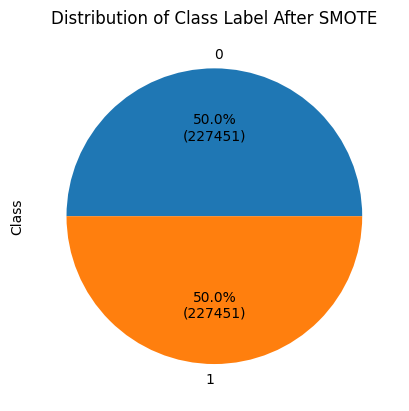

In [69]:
# Your code here
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_dev_smote, y_dev_smote = smote.fit_resample(X_dev, y_dev)

val_counts = pd.Series(y_dev_smote).value_counts(sort=False)
num_neg = val_counts[0]
num_pos = val_counts[1]
num_rows = num_neg + num_pos

def pct_func(pct):
    val = int(np.around((pct * num_rows)/100))
    return '{p:.1f}%\n({v:d})'.format(p=pct,v=val)

ax = val_counts.plot(kind="pie", autopct=pct_func)
ax.set_title("Distribution of Class Label After SMOTE")

print("After Sampling ---")
print("Number of Observations: \t", num_rows)
print("Number of positive cases: \t", num_pos)
print("Number of negative cases: \t", num_neg)
print("Dev Feature Shape: ", X_dev_smote.shape)

**1.3.7 Repeat 1.3.1 using the dataset you created in the above step(1.3.6 SMOTE). (Make sure you use the same hyperparameters as 1.3.1. i.e., max_depth=10 and random_state=42. This will help us to compare the models)**

In [70]:
# Your Code here
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from imblearn.pipeline import make_pipeline as imb_make_pipeline
dt_smote = DecisionTreeClassifier(max_depth=10, random_state=42)

pipeline_smote = imb_make_pipeline(smote, dt_smote)

# Using stratified K fold due to the imbalance
kfold = StratifiedKFold(n_splits=5)

pipeline_smote.fit(X_dev, y_dev)

scores_smote = cross_validate(pipeline_smote, X=X_dev, y=y_dev, cv=kfold, scoring=['roc_auc', 'average_precision'])

print("AUC: \t\t\t", np.mean(scores_smote['test_roc_auc']))
print("Average Precision: \t", np.mean(scores_smote['test_average_precision']))

AUC: 			 0.9023022248050829
Average Precision: 	 0.4705691055171962


**1.3.8 Make predictions on the test set using the four models that you built and report their AUC values.**

In [71]:
# Your Code here
from sklearn.metrics import roc_auc_score

# Get all the predictions
yhat_base = dt.predict(X_test)
yhat_over = dt_over.predict(X_test)
yhat_under = dt_under.predict(X_test)
yhat_smote = dt_smote.predict(X_test)

# Evalute the predictions
score_base = roc_auc_score(y_test, yhat_base)
score_over = roc_auc_score(y_test, yhat_over)
score_under = roc_auc_score(y_test, yhat_under)
score_smote = roc_auc_score(y_test, yhat_smote)

print("Test Metrics --")
print("ROC - Base: ", score_base)
print("ROC - Over: ", score_over)
print("ROC - Under: ", score_under)
print("ROC - Smote: ", score_smote)

Test Metrics --
ROC - Base:  0.8774367125859911
ROC - Over:  0.8984097754183272
ROC - Under:  0.9149356000137815
ROC - Smote:  0.9062661502417511


**1.3.9 Plot Confusion Matrices for all the four models on the test set. Comment your results**

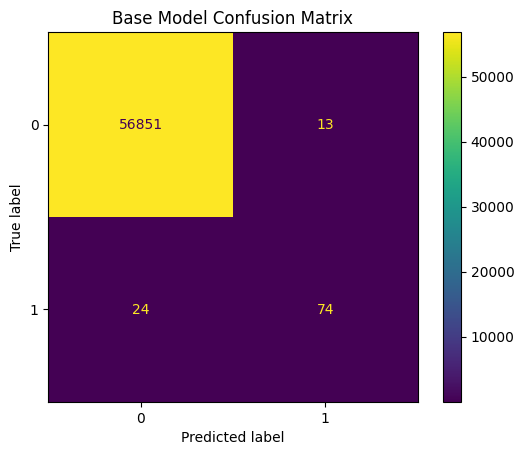

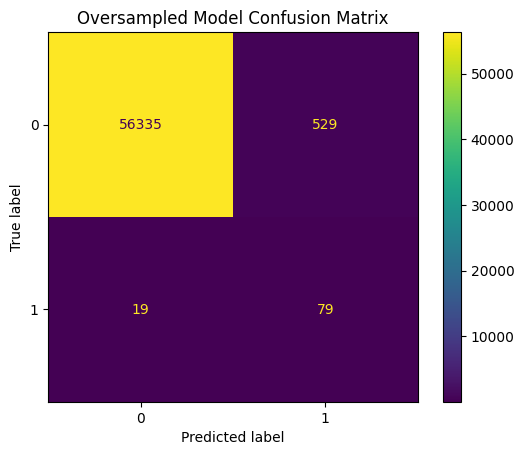

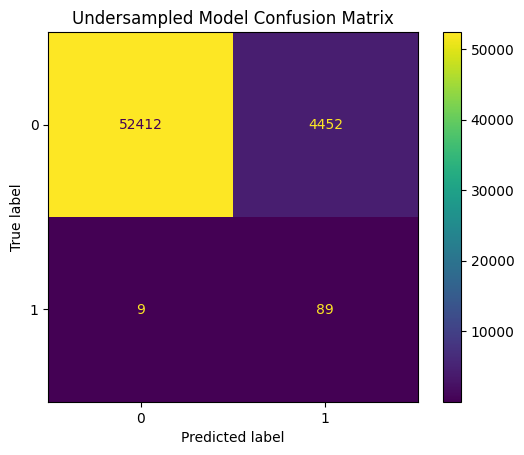

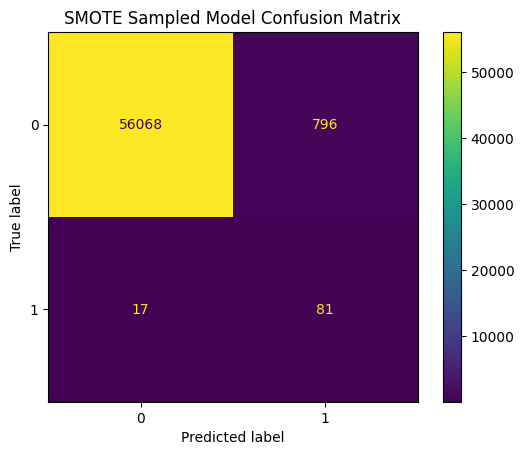

' \nThey all seem to have a very large number of True-negative samples.\nThis is probably due to the fact that negative examples make up most of the dataset.\nThe different sampling techniques aim to balance out the number of possitive and negative examples in the dataset.\nWe can see that the sampling methods all improved on their TPR:FNR ratio (AUROC), showing that the sampling helped improve some detection of our minority class.\nThough, many of the models increase the number of FP predictions, especially the Undersampled model, hurting the AP.\n'

In [72]:
# Your Code here
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test)
plt.title("Base Model Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_estimator(dt_over, X_test, y_test)
plt.title("Oversampled Model Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_estimator(dt_under, X_test, y_test)
plt.title("Undersampled Model Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_estimator(dt_smote, X_test, y_test)
plt.title("SMOTE Sampled Model Confusion Matrix")
plt.show()

""" 
They all seem to have a very large number of True-negative samples.
This is probably due to the fact that negative examples make up most of the dataset.
The different sampling techniques aim to balance out the number of possitive and negative examples in the dataset.
We can see that the sampling methods all improved on their TPR:FNR ratio (AUROC), showing that the sampling helped improve some detection of our minority class.
Though, many of the models increase the number of FP predictions, especially the Undersampled model, hurting the AP.
"""

**1.3.10 Plot ROC for all the four models on the test set in a single plot. Make sure you label axes and legend properly. Comment your results**

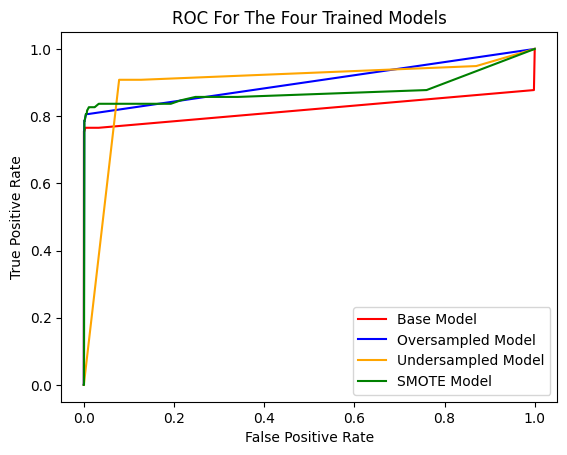

' \nThey seem to all be quite similiar, with a bit of distinction in the undersampled model.\nNoteably, from the metrics printed earlier, the area under the sampled models is a little better than the non-sampled models.\nDue to the increase in the FPR:FNR ratio.  The undersampled model has the best, since it has one of the highest positive prediction rates, but this also causes the Average Precision (AP) to be affected.\n'

In [73]:
# Your code
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, dt.predict_proba(X_test)[:,1])
fpr_over, tpr_over, _ = roc_curve(y_test, dt_over.predict_proba(X_test)[:,1])
fpr_under, tpr_under, _ = roc_curve(y_test, dt_under.predict_proba(X_test)[:,1])
fpr_smote, tpr_smote, _ = roc_curve(y_test, dt_smote.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, color='red', label="Base Model")
plt.plot(fpr_over, tpr_over, color='blue', label="Oversampled Model")
plt.plot(fpr_under, tpr_under, color='orange', label="Undersampled Model")
plt.plot(fpr_smote, tpr_smote, color='green', label="SMOTE Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC For The Four Trained Models")
plt.legend()
plt.show()

""" 
They seem to all be quite similiar, with a bit of distinction in the undersampled model.
Noteably, from the metrics printed earlier, the area under the sampled models is a little better than the non-sampled models.
Due to the increase in the FPR:FNR ratio.  The undersampled model has the best, since it has one of the highest positive prediction rates, but this also causes the Average Precision (AP) to be affected.
"""


**1.3.11 Plot Precision-recall curve for all four models on test set in a single plot. Make sure you label the axes and legend properly. Comment on your results**

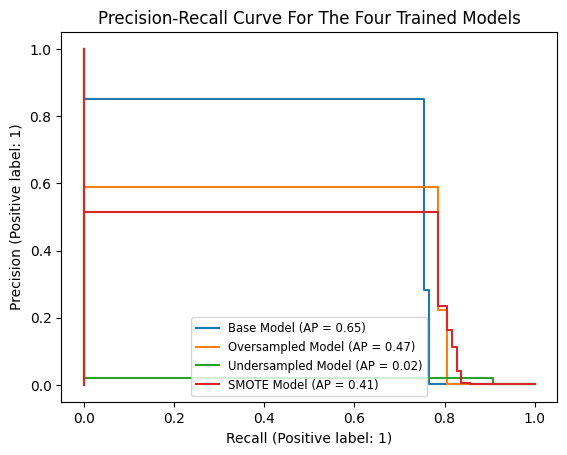

" \nThere appears be to be quite a sudden dropoff for most models in precision around 0.8 recall.\nAlso, the undersampled model seems to always have quite a low precision\n\nAs mentioned in the comment on the Confusion Matrix's, the sampled models prediced increased FPs.  \nWhile they often increased their FPR:FNR ratios, this still caused them to see a decrease in Average Precicion.\n"

In [74]:
# Your code here
from sklearn.metrics import PrecisionRecallDisplay

plt.figure()
ax = plt.gca()
PrecisionRecallDisplay.from_estimator(dt, X_test, y_test, ax=ax, name="Base Model")
PrecisionRecallDisplay.from_estimator(dt_over, X_test, y_test, ax=ax, name="Oversampled Model")
PrecisionRecallDisplay.from_estimator(dt_under, X_test, y_test, ax=ax, name="Undersampled Model")
PrecisionRecallDisplay.from_estimator(dt_smote, X_test, y_test, ax=ax, name="SMOTE Model")
plt.title("Precision-Recall Curve For The Four Trained Models")
plt.legend(fontsize='small')
plt.show()

""" 
There appears be to be quite a sudden dropoff for most models in precision around 0.8 recall.
Also, the undersampled model seems to always have quite a low precision

As mentioned in the comment on the Confusion Matrix's, the sampled models prediced increased FPs.  
While they often increased their FPR:FNR ratios, this still caused them to see a decrease in Average Precicion.
"""


<!-- **1.3.12 Train a balanced Decision tree classifier. (You can use max_depth=10 and random_state=42)( balance the class weights). Print the AUC and average precision on test set** (Use Random state = 42) -->

**1.3.12 Train a balanced default Decision tree classifier. (use max_depth=10 and random_state=42). (balance the class weight).  Print the AUC and average precision on dev set.**

In [52]:
# Your code here
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

val_counts = pd.Series(y_dev).value_counts(sort=False)
num_neg = val_counts[0]
num_pos = val_counts[1]
num_rows = num_neg + num_pos

# Give each class a weight that will offset the difference 
dt_bal = DecisionTreeClassifier(max_depth=10, random_state=42, class_weight={0:num_pos,1:num_neg})

# Using stratified K fold due to the imbalance
kfold = StratifiedKFold(n_splits=5)

dt.fit(X_dev, y_dev)

scores = cross_validate(dt_bal, X=X_dev, y=y_dev, cv=kfold, scoring=['roc_auc', 'average_precision'])

print("AUC: \t\t\t", np.mean(scores['test_roc_auc']))
print("Average Precision: \t", np.mean(scores['test_average_precision']))

AUC: 			 0.9042424827563549
Average Precision: 	 0.5228018487057429
